In [38]:
# A cell to run functions directly.
using Reexport
using Distributions
using Statistics
using GeoStats
using Random
using DataFrames
import GLMakie as Mke
using Infiltrator
using AbstractGPs
using Unitful
using Plots
using DataStructures
using POMDPs
include("../src/config.jl");
include("../src/pomdp.jl")
pomdp = CCSPOMDP();

FEATURE = :topSealThickness


:topSealThickness

In [31]:
total_grid_suitability = 0. # This method stratifies sampling on rock type.
for rocktype in 1:length(instances(RockType))
    if pomdp.rocktype_belief[1].p[rocktype] == 0.0
        # Assumption: Layer 1 rocktype is known, meaning we must have taken a well action, 
        # so all layer rock types are known. If this becomes problematic, just move these lines
        # down into the next loop.
        continue 
    end
    for layer in 1:NUM_LAYERS
        gridx = pcu([pt.vertices[1] for pt in domain(pomdp.state.earth[layer].gt)])
        sample_values = zeros(length(gridx) * SUITABILITY_NSAMPLES)
        for column in pomdp.feature_names
            fgrid = pomdp.belief[rocktype][layer][column](gridx)
            fs = marginals(fgrid)
            marginal_means = mean.(fs)
            marginal_stds = std.(fs)
            norms = [Normal(μ, σ) for (μ, σ) in zip(marginal_means, marginal_stds)]
            incr = [score_component(column, rand(N)) for N in norms for _ in 1:SUITABILITY_NSAMPLES]
            println(size(sample_values))
            println(size(incr))
            sample_values .+= incr
        end
        sample_values ./= length(pomdp.feature_names)
        sample_matr = reshape(sample_values, length(gridx), SUITABILITY_NSAMPLES)
        bits_matr = sample_matr .> SUITABILITY_THRESHOLD
        suitable_pts = (Statistics.mean(bits_matr, dims=2) .>= SUITABILITY_CONF_THRESHOLD)
        total_grid_suitability += 1.0 * sum(suitable_pts) * pomdp.rocktype_belief[layer].p[rocktype]

        bits_matr = .!bits_matr
        unsuitable_pts = (Statistics.mean(bits_matr, dims=2) .>= SUITABILITY_CONF_THRESHOLD)
        total_grid_suitability += SUITABILITY_BIAS * sum(unsuitable_pts) * pomdp.rocktype_belief[layer].p[rocktype]
    end
end
return total_grid_suitability

(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)
(250000,)


34999.999999999985

In [ ]:
total_grid_suitability = 0. # This method stratifies sampling on rock type.
for layer in 1:NUM_LAYERS
    gridx = pcu([pt.vertices[1] for pt in domain(pomdp.state.earth[layer].gt)])
    npts = length(gridx)
    sample_values = zeros(npts * SUITABILITY_NSAMPLES)
    prob_mask = zeros(SUITABILITY_NSAMPLES)
    for column in pomdp.feature_names
        prev_end = 0
        for rocktype in 1:length(instances(RockType))
            belief_prob = pomdp.rocktype_belief[layer].p[rocktype]
            rocktype_nsamples = Int(floor(belief_prob * SUITABILITY_NSAMPLES))
            println(rocktype_nsamples)
            println(belief_prob)
            fgrid = pomdp.belief[rocktype][layer][column](gridx)
            fs = marginals(fgrid)
            marginal_means = mean.(fs)
            marginal_stds = std.(fs)
            norms = [Normal(μ, σ) for (μ, σ) in zip(marginal_means, marginal_stds)]
            incr = [score_component(column, rand(N)) for N in norms for _ in 1:rocktype_nsamples]
            println("$prev_end $(prev_end + rocktype_nsamples) ",
                     size(sample_values[npts * prev_end + 1: npts * (prev_end + rocktype_nsamples)]))
            println(size(incr))
            sample_values[npts * prev_end + 1: npts * (prev_end + rocktype_nsamples)] .+= incr
            prob_mask[prev_end + 1:prev_end + rocktype_nsamples] .= rocktype
            prev_end += rocktype_nsamples * npts
        end
    end
    # sample_values ./= length(pomdp.feature_names)
    # sample_matr = reshape(sample_values, length(gridx), SUITABILITY_NSAMPLES)
    # bits_matr = sample_matr .> SUITABILITY_THRESHOLD
    # bits_matr = bits_matr .* prob_mask
    # suitable_pts = (Statistics.mean(bits_matr, dims=2) .>= SUITABILITY_CONF_THRESHOLD)
    # total_grid_suitability += 1.0 * sum(suitable_pts) * pomdp.rocktype_belief[layer].p[rocktype]

    # bits_matr = .!bits_matr
    # unsuitable_pts = (Statistics.mean(bits_matr, dims=2) .>= SUITABILITY_CONF_THRESHOLD)
    # total_grid_suitability += SUITABILITY_BIAS * sum(unsuitable_pts) * pomdp.rocktype_belief[layer].p[rocktype]
end
# return total_grid_suitability


8
0.3333333333333333
1 80000 (80000,)
(80000,)
8
0.3333333333333333
80001 160000 (80000,)
(80000,)


BoundsError: BoundsError: attempt to access 24-element Vector{Float64} at index [80001:80008]

In [15]:
visualize_gt(pomdp, 2)

### Test: Action function returns all actions

In [16]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

  1.289022 seconds (27.34 M allocations: 1.166 GiB, 6.88% gc time, 5.88% compilation time: 84% of which was recompilation)
  0.888299 seconds (14.22 M allocations: 841.012 MiB, 7.01% gc time, 17.57% compilation time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: -1.3435534273938257e12


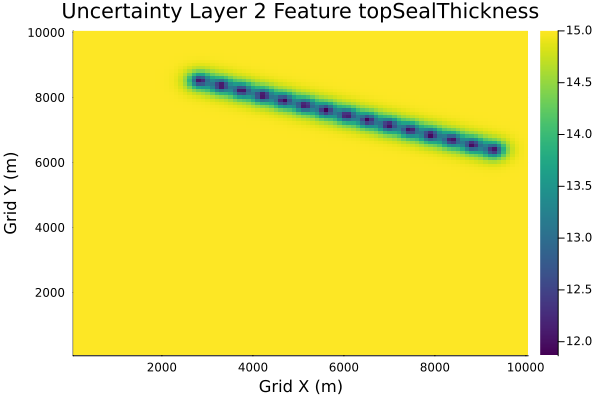

In [17]:
# Taking a seismic line action first
distr = POMDPs.observation(pomdp, all_actions[21], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[21])
println(typeof(distr), "\nReward: ", reward)

visualize_uncertainty(pomdp, 2, FEATURE)

In [18]:
pomdp.rocktype_belief

5-element Vector{Distributions.Categorical{Float64, Vector{Float64}}}:
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])

In [19]:
distr = POMDPs.observation(pomdp, all_actions[2], pomdp.state);
pomdp.rocktype_belief

5-element Vector{Distributions.Categorical{Float64, Vector{Float64}}}:
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[1.0, 0.0, 0.0])

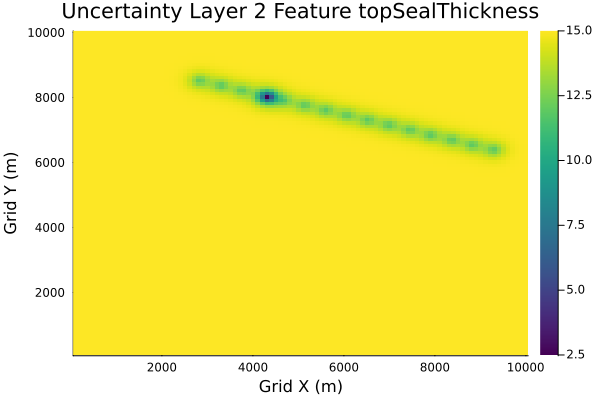

In [20]:
visualize_uncertainty(pomdp, 2, FEATURE)

  0.815884 seconds (10.09 M allocations: 442.664 MiB, 42.39% gc time, 6.72% compilation time: 55% of which was recompilation)
  0.284906 seconds (5.05 M allocations: 292.908 MiB, 10.42% gc time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 9.636518426324463e6


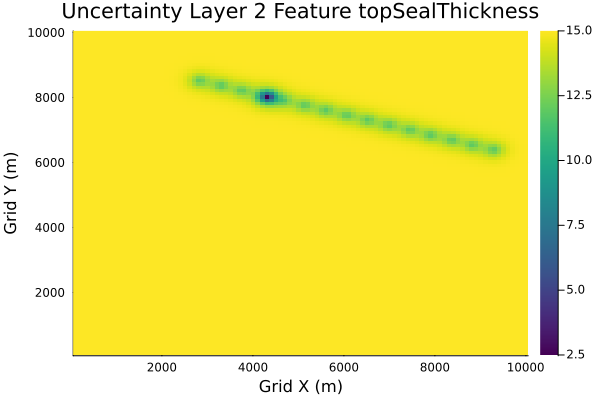

In [21]:
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[2])
println(typeof(distr), "\nReward: ", reward)

visualize_uncertainty(pomdp, 2, FEATURE)

  0.825614 seconds (18.92 M allocations: 800.001 MiB, 5.39% gc time)
  0.457001 seconds (9.55 M allocations: 476.014 MiB, 6.07% gc time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 1.0151198025930048e10


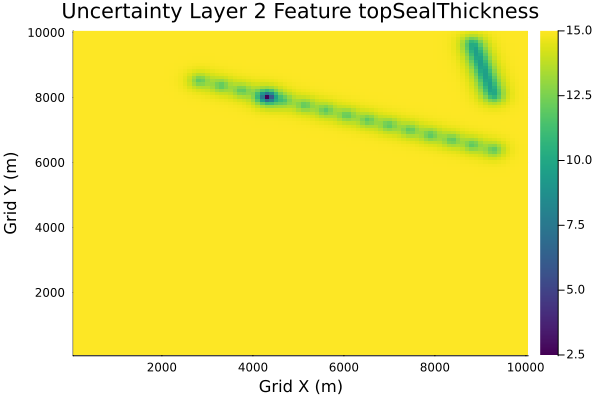

In [22]:
# Timing test for seismic line observation and reward function
distr = POMDPs.observation(pomdp, all_actions[19], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[19])
println(typeof(distr), "\nReward: ", reward)
visualize_uncertainty(pomdp, 2, FEATURE)

  0.874576 seconds (19.82 M allocations: 836.622 MiB, 6.16% gc time)
  0.477549 seconds (10.00 M allocations: 494.324 MiB, 6.60% gc time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 3.1755773622277465e9


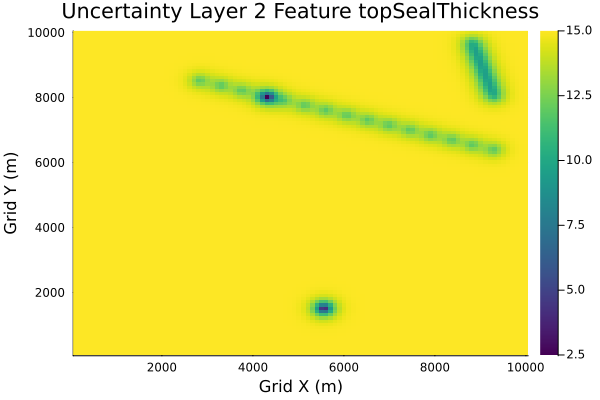

In [23]:
# Timing test for well log observation and reward function
distr = POMDPs.observation(pomdp, all_actions[1], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[1])
println(typeof(distr), "\nReward: ", reward)
visualize_uncertainty(pomdp, 2, FEATURE)